Original Version from tensorflow.org
Available @ https://www.tensorflow.org/tutorials/images/classification

Recreation in Tensorflow 2.5 (& Python 3.8) by Amir Hossini:
 - Addition of ImageDataGenerator
 - Split Function
 - Loss Function: categorical_cross_entropy (instead of sparse_categorical_cross_entropy)
 - Custom Callbacks: min required accuracy
 - Addition of image augmentation
 - Addition of drop-out
 - Addition of class prediction

Num GPUs Available:  1
data directory:  C:\Users\Windows\OneDrive\Certifications\2021_10_Tensorflow_Prof_Cert\04-Tensorflow-NotebooksGit\00-Simple_DNN_and_CNN/datasets/flower_photos
image count =  3671
Found 2934 images belonging to 5 classes.
Found 736 images belonging to 5 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None,

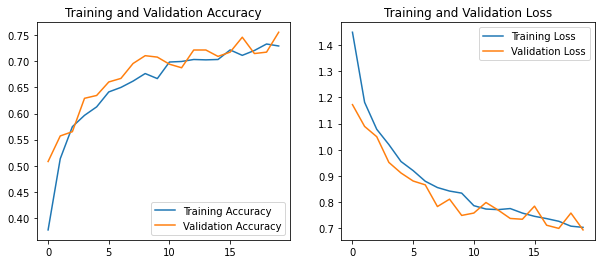

In [2]:
## Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import shutil
from shutil import copyfile
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

## GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

## Folder setup
data_folder=f"{os.getcwd()}/datasets/flower_photos"

## Parameters
seed             = 42

split_size       = 0.8
batch_size_train = 32
batch_size_valid = 16
img_height       = 180
img_width        = 180

max_n_epochs     = 20

## Set random seed
tf.random.set_seed=seed

## Functions
class Callback_set(tf.keras.callbacks.Callback):

    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') is not None and logs.get('val_accuracy') > 0.9):
            print(f"\nReached 90% validation accuracy so cancelling training!")
            self.model.stop_training = True

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE, seed=42):
  random.seed(seed)
  src_list = os.listdir(SOURCE)
  src_shuf = random.sample(src_list, len(src_list))
  src_clnn = []

  for ifile in src_shuf:
    fpath = os.path.join(SOURCE, ifile)
    fsize = os.path.getsize(fpath)
    if fsize > 0:
      src_clnn.append(ifile)

  src_train = src_clnn[:int(len(src_clnn) * SPLIT_SIZE)]
  src_test = src_clnn[int(len(src_clnn) * SPLIT_SIZE):]

  for itrain in src_train:
    fsrc = os.path.join(SOURCE, itrain)
    fdes = os.path.join(TRAINING, itrain)
    copyfile(fsrc, fdes)

  for itest in src_test:
    fsrc = os.path.join(SOURCE, itest)
    fdes = os.path.join(TESTING, itest)
    copyfile(fsrc, fdes)
  return

def model_compile(num_classes):
    model = Sequential([
        layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation=tf.keras.activations.softmax)
    ])
    print(model.summary())

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    """
    Attention must be paid to application of sparse_categorical vs categorical_cross_entropy for loss functions 
    when working with image generators:
    https://stackoverflow.com/questions/49161174/tensorflow-logits-and-labels-must-have-the-same-first-dimension
    """
    return model

## Load Data

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
shutil.copytree(data_dir,data_folder,dirs_exist_ok=True)

print('data directory: ',format(data_folder))

"""
Folder structure
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
"""

## Image count and vizi

image_count = sum([len(files) for r, d, files in os.walk(data_folder)])
print('image count = ', image_count)

roses = list(os.listdir(os.path.join(data_folder,'roses')))
tulips = list(os.listdir(os.path.join(data_folder,'tulips')))
PIL.Image.open(os.path.join(os.path.join(data_folder,'roses'),str(roses[0])))#.show()
PIL.Image.open(os.path.join(os.path.join(data_folder,'tulips'),str(tulips[0])))#.show()

## Train-test split
shutil.rmtree(f"{os.getcwd()}/tmp", ignore_errors=True)
train_dir      = os.path.join(f"{os.getcwd()}/tmp",'train')
validation_dir = os.path.join(f"{os.getcwd()}/tmp",'validation')

categories    = [dirs for r,dirs,f in os.walk(data_folder)][0]
for catg in categories:
  source_cat    = os.path.join(data_folder,catg)
  train_dir_cat = os.path.join(train_dir,catg)
  os.makedirs(train_dir_cat, exist_ok=True)
  valid_dir_cat = os.path.join(validation_dir,catg)
  os.makedirs(valid_dir_cat, exist_ok=True)
  split_data(source_cat,train_dir_cat,valid_dir_cat,split_size,seed)

nfl_train = sum([len(f) for r,d,f in os.walk(train_dir)])
nfl_valid = sum([len(f) for r,d,f in os.walk(validation_dir)])

dgen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                             rotation_range=40,
                                                             width_shift_range=0.2,
                                                             height_shift_range=0.2,
                                                             shear_range=0.2,
                                                             zoom_range=0.2,
                                                             horizontal_flip=True,
                                                             fill_mode='nearest'
                                                             )

dgen_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,
                                                             rotation_range=40,
                                                             width_shift_range=0.2,
                                                             height_shift_range=0.2,
                                                             shear_range=0.2,
                                                             zoom_range=0.2,
                                                             horizontal_flip=True,
                                                             fill_mode='nearest'
                                                             )

train_gen = dgen_train.flow_from_directory(train_dir,
                                           batch_size=batch_size_train,
                                           class_mode='categorical',
                                           target_size=(img_height,img_width)
                                           )
valid_gen = dgen_valid.flow_from_directory(validation_dir,
                                           batch_size=batch_size_valid,
                                           class_mode='categorical',
                                           target_size=(img_height,img_width)
                                           )


my_callbacks = Callback_set()
model        = model_compile(len(categories))
history      = model.fit(train_gen,
                         steps_per_epoch  = int(nfl_train / batch_size_train),
                         validation_data  = valid_gen,
                         validation_steps = int(nfl_valid / batch_size_valid),
                         epochs           = max_n_epochs,
                         callbacks        = [my_callbacks]
                         )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [3]:
from tensorflow.keras.preprocessing import image
from matplotlib.pyplot import imshow

np.random.seed(0)

n_files       = 5
path_to_files = './datasets/flower_photos'

pix_all       = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.path.expanduser(path_to_files)) for f in fn if f.split('.')[1]=='jpg']
pix_list      = np.random.choice(pix_all,n_files)

icount=0
for item in pix_list:
    img = image.load_img(item, target_size=(img_height,img_width))
    x   = image.img_to_array(img)
    x   = np.expand_dims(x, axis=0)
    if icount==0:
        images = x
    images = np.vstack([images,x])
    icount+=1
classes = model.predict(images, batch_size=10)
print(classes)

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]
